In [1]:
import numpy as np
%matplotlib widget
from matplotlib.widgets import Button, CheckButtons
from matplotlib.patches import FancyArrowPatch
import matplotlib.pyplot as plt
import time, copy
from ipywidgets import Output
plt.style.use('./deeplearning.mplstyle')
from plt_one_addpt_onclick import plt_one_addpt_onclick

In [2]:
x_train = np.array([0., 1, 2, 3, 4, 5])
y_train = np.array([0,  0, 0, 1, 1, 1])
X_train2 = np.array([[0.5, 1.5], [1,1], [1.5, 0.5], [3, 0.5], [2, 2], [1, 2.5]])
y_train2 = np.array([0, 0, 0, 1, 1, 1])

In [5]:
def plot_data(X, y, ax, pos_label="y=1", neg_label="y=0", s=80, loc='best' ):
    """ plots logistic data with two axis """
    # Find Indices of Positive and Negative Examples
    pos = y == 1
    neg = y == 0
    pos = pos.reshape(-1,)  #work with 1D or 1D y vectors
    neg = neg.reshape(-1,)

    # Plot examples
    ax.scatter(X[pos, 0], X[pos, 1], marker='x', s=s, c = 'red', label=pos_label)
    ax.scatter(X[neg, 0], X[neg, 1], marker='o', s=s, label=neg_label, fc='none', ec='blue', lw=3)
    ax.legend(loc=loc)

    ax.figure.canvas.toolbar_visible = False
    ax.figure.canvas.header_visible = False
    ax.figure.canvas.footer_visible = False

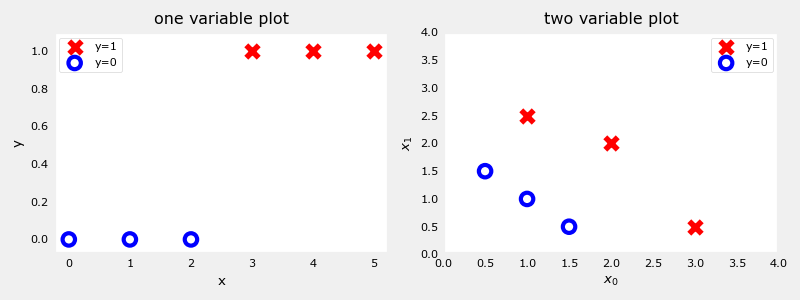

In [6]:
pos = y_train == 1
neg = y_train == 0

fig, ax = plt.subplots(1, 2, figsize=(8, 3))
ax[0].scatter(x_train[pos], y_train[pos], marker='x', s=80, c='r',label='y=1')
ax[0].scatter(x_train[neg], y_train[neg], marker='o', s=80, fc='none', ec='blue',label='y=0', lw=3)
ax[0].set_ylim(-0.08,1.1)
ax[0].set_ylabel('y')
ax[0].set_xlabel('x')
ax[0].set_title('one variable plot')
ax[0].legend()

#plot 2, two variables
plot_data(X_train2, y_train2, ax[1])
ax[1].axis([0, 4, 0, 4])
ax[1].set_ylabel('$x_1$')
ax[1].set_xlabel('$x_0$')
ax[1].set_title('two variable plot')
ax[1].legend()
plt.tight_layout()
plt.show()

In [7]:
from lab_utils_common import np, plt, dlblue, dlorange, sigmoid, dldarkred, gradient_descent

# for debug
# output = Output() # sends hidden error messages to display when using widgets
# display(output)

class plt_one_addpt_onclick:
    """ class to run one interactive plot """
    def __init__(self, x, y, w, b, logistic=True):
        self.logistic=logistic
        pos = y == 1
        neg = y == 0

        fig,ax = plt.subplots(1,1,figsize=(8,4))
        fig.canvas.toolbar_visible = False
        fig.canvas.header_visible = False
        fig.canvas.footer_visible = False

        plt.subplots_adjust(bottom=0.25)
        ax.scatter(x[pos], y[pos], marker='x', s=80, c = 'red', label="malignant")
        ax.scatter(x[neg], y[neg], marker='o', s=100, label="benign", facecolors='none', edgecolors=dlblue,lw=3)
        ax.set_ylim(-0.05,1.1)
        xlim = ax.get_xlim()
        ax.set_xlim(xlim[0],xlim[1]*2)
        ax.set_ylabel('y')
        ax.set_xlabel('Tumor Size')
        self.alegend = ax.legend(loc='lower right')
        if self.logistic:
            ax.set_title("Example of Logistic Regression on Categorical Data")
        else:
            ax.set_title("Example of Linear Regression on Categorical Data")

        ax.text(0.65,0.8,"[Click to add data points]", size=10, transform=ax.transAxes)

        axcalc   = plt.axes([0.1, 0.05, 0.38, 0.075])  #l,b,w,h
        axthresh = plt.axes([0.5, 0.05, 0.38, 0.075])  #l,b,w,h
        self.tlist = []

        self.fig = fig
        self.ax = [ax,axcalc,axthresh]
        self.x = x
        self.y = y
        self.w = copy.deepcopy(w)
        self.b = b
        f_wb = np.matmul(self.x.reshape(-1,1), self.w) + self.b
        if self.logistic:
            self.aline = self.ax[0].plot(self.x, sigmoid(f_wb), color=dlblue)
            self.bline = self.ax[0].plot(self.x, f_wb, color=dlorange,lw=1)
        else:
            self.aline = self.ax[0].plot(self.x, sigmoid(f_wb), color=dlblue)

        self.cid = fig.canvas.mpl_connect('button_press_event', self.add_data)
        if self.logistic:
            self.bcalc = Button(axcalc, 'Run Logistic Regression (click)', color=dlblue)
            self.bcalc.on_clicked(self.calc_logistic)
        else:
            self.bcalc = Button(axcalc, 'Run Linear Regression (click)', color=dlblue)
            self.bcalc.on_clicked(self.calc_linear)
        self.bthresh = CheckButtons(axthresh, ('Toggle 0.5 threshold (after regression)',))
        self.bthresh.on_clicked(self.thresh)

        # Force the figure to render first
        # self.fig.canvas.draw_idle()  
        self.resize_sq(self.bthresh)

 #   @output.capture()  # debug
    def add_data(self, event):
        #self.ax[0].text(0.1,0.1, f"in onclick")
        if event.inaxes == self.ax[0]:
            x_coord = event.xdata
            y_coord = event.ydata

            if y_coord > 0.5:
                self.ax[0].scatter(x_coord, 1, marker='x', s=80, c = 'red' )
                self.y = np.append(self.y,1)
            else:
                self.ax[0].scatter(x_coord, 0, marker='o', s=100, facecolors='none', edgecolors=dlblue,lw=3)
                self.y = np.append(self.y,0)
            self.x = np.append(self.x,x_coord)
        self.fig.canvas.draw()

#   @output.capture()  # debug
    def calc_linear(self, event):
        if self.bthresh.get_status()[0]:
            self.remove_thresh()
        for it in [1,1,1,1,1,2,4,8,16,32,64,128,256]:
            self.w, self.b, _ = gradient_descent(self.x.reshape(-1,1), self.y.reshape(-1,1),
                                                 self.w.reshape(-1,1), self.b, 0.01, it,
                                                 logistic=False, lambda_=0, verbose=False)
            self.aline[0].remove()
            self.alegend.remove()
            y_hat = np.matmul(self.x.reshape(-1,1), self.w) + self.b
            self.aline = self.ax[0].plot(self.x, y_hat, color=dlblue,
                                         label=f"y = {np.squeeze(self.w):0.2f}x+({self.b:0.2f})")
            self.alegend = self.ax[0].legend(loc='lower right')
            time.sleep(0.3)
            self.fig.canvas.draw()
        if self.bthresh.get_status()[0]:
            self.draw_thresh()
            self.fig.canvas.draw()

    def calc_logistic(self, event):
        if self.bthresh.get_status()[0]:
            self.remove_thresh()
        for it in [1, 8,16,32,64,128,256,512,1024,2048,4096]:
            self.w, self.b, _ = gradient_descent(self.x.reshape(-1,1), self.y.reshape(-1,1),
                                                 self.w.reshape(-1,1), self.b, 0.1, it,
                                                 logistic=True, lambda_=0, verbose=False)
            self.aline[0].remove()
            self.bline[0].remove()
            self.alegend.remove()
            xlim  = self.ax[0].get_xlim()
            x_hat = np.linspace(*xlim, 30)
            y_hat = sigmoid(np.matmul(x_hat.reshape(-1,1), self.w) + self.b)
            self.aline = self.ax[0].plot(x_hat, y_hat, color=dlblue,
                                         label="y = sigmoid(z)")
            f_wb = np.matmul(x_hat.reshape(-1,1), self.w) + self.b
            self.bline = self.ax[0].plot(x_hat, f_wb, color=dlorange, lw=1,
                                         label=f"z = {np.squeeze(self.w):0.2f}x+({self.b:0.2f})")
            self.alegend = self.ax[0].legend(loc='lower right')
            time.sleep(0.3)
            self.fig.canvas.draw()
        if self.bthresh.get_status()[0]:
            # self.remove_thresh()
            self.draw_thresh()
            self.fig.canvas.draw()


    def thresh(self, event):
        if self.bthresh.get_status()[0]:
            # plt.figtext(0,0, f"in thresh {self.bthresh.get_status()}")
            self.draw_thresh()
        else:
            # plt.figtext(0,0.3, f"in thresh {self.bthresh.get_status()}")
            self.remove_thresh()

    def draw_thresh(self):
        ws = np.squeeze(self.w)
        xp5 = -self.b/ws if self.logistic else (0.5 - self.b) / ws
        ylim = self.ax[0].get_ylim()
        xlim = self.ax[0].get_xlim()
        a = self.ax[0].fill_between([xlim[0], xp5], [ylim[1], ylim[1]], alpha=0.2, color=dlblue)
        b = self.ax[0].fill_between([xp5, xlim[1]], [ylim[1], ylim[1]], alpha=0.2, color=dldarkred)
        c = self.ax[0].annotate("Malignant", xy= [xp5,0.5], xycoords='data',
             xytext=[30,5],textcoords='offset points')
        d = FancyArrowPatch(
            posA=(xp5, 0.5), posB=(xp5+1.5, 0.5), color=dldarkred,
            arrowstyle='simple, head_width=5, head_length=10, tail_width=0.0',
        )
        self.ax[0].add_artist(d)

        e = self.ax[0].annotate("Benign", xy= [xp5,0.5], xycoords='data',
                     xytext=[-70,5],textcoords='offset points', ha='left')
        f = FancyArrowPatch(
            posA=(xp5, 0.5), posB=(xp5-1.5, 0.5), color=dlblue,
            arrowstyle='simple, head_width=5, head_length=10, tail_width=0.0',
        )
        self.ax[0].add_artist(f)
        self.tlist = [a,b,c,d,e,f]

        self.fig.canvas.draw()

    def remove_thresh(self):
        #plt.figtext(0.5,0.0, f"rem thresh {self.bthresh.get_status()}")
        for artist in self.tlist:
            artist.remove()
        self.fig.canvas.draw()

    # def resize_sq(self, bcid):
    #     """ resizes the check box """
    #     #future reference
    #     #print(f"width  : {bcid.rectangles[0].get_width()}")
    #     #print(f"height : {bcid.rectangles[0].get_height()}")
    #     #print(f"xy     : {bcid.rectangles[0].get_xy()}")
    #     #print(f"bb     : {bcid.rectangles[0].get_bbox()}")
    #     #print(f"points : {bcid.rectangles[0].get_bbox().get_points()}")  #[[xmin,ymin],[xmax,ymax]]

    #     h = bcid.rectangles[0].get_height()
    #     bcid.rectangles[0].set_height(3*h)

    #     ymax = bcid.rectangles[0].get_bbox().y1
    #     ymin = bcid.rectangles[0].get_bbox().y0

    #     bcid.lines[0][0].set_ydata([ymax,ymin])
    #     bcid.lines[0][1].set_ydata([ymin,ymax])

    def resize_sq(self, bcid):
        rects = getattr(bcid, "rectangles", None) or getattr(bcid, "boxes", None)
        if not rects or len(rects) == 0:
            return  # safely skip if boxes not ready

        h = rects[0].get_height()
        rects[0].set_height(3 * h)

        ymax = rects[0].get_bbox().y1
        ymin = rects[0].get_bbox().y0

        if hasattr(bcid, "lines") and len(bcid.lines) > 0:
            bcid.lines[0][0].set_ydata([ymax, ymin])
            bcid.lines[0][1].set_ydata([ymin, ymax])

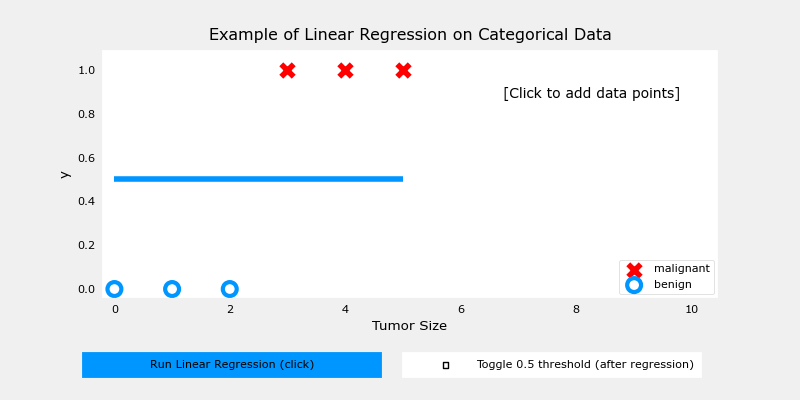

In [8]:
w_in = np.zeros((1))
b_in = 0
plt.close('all') 
addpt = plt_one_addpt_onclick(x_train, y_train, w_in, b_in, logistic=False)

In [10]:
plt.close('all')